In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../Code/')
import adaprobe
import time
import seaborn as sns
from scipy.sparse import csc_matrix
from sklearn.linear_model import Lasso
import imageio as io
from adaprobe.optimise.cavi_online_spike_and_slab import _sample_phi_independent_truncated_normals
from scipy.stats import norm

In [4]:
fontsize = 12

In [5]:
dat = np.load('../Data/npy/201118_cell1_A.npy', allow_pickle=True).item()
img = io.imread('../Data/tiff/201118_cell1_merge2.tif')

In [6]:
cell_locs = dat['cell_locs']
order = dat['stim_order']
stimuli = dat['stimuli']
targets = dat['targets']
responses = dat['responses']

L = stimuli[:, :3]
I = stimuli[:, -1]

y = np.trapz(responses, axis=1)

# Blind maps

In [7]:
def find_common(arrs):
    """Recursive algorithm for finding common elements in a list of arrays.
    """
    if len(arrs) == 1:
        return arrs[0]
    elif len(arrs) == 2:
        return np.intersect1d(arrs[0], arrs[1])
    else:
        return np.intersect1d(arrs[0], find_common(arrs[1:]))

def find_stim_id(loc):
    return find_common([np.where(loc[i] == targets[:, i])[0] for i in range(3)])

def lasso_map(power):
    trial_locs = np.where(I == power)[0]
    cols = np.array([find_stim_id(L[trial_locs[i]]) for i in range(len(trial_locs))]).squeeze()
    rows = np.array(range(len(cols)))
    sparse_data = np.ones(len(cols))
    A = csc_matrix((sparse_data, (rows, cols)))
    
    alpha = 1e-4
    sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
    sparse_lasso.fit(A, y[trial_locs])
    
    return sparse_lasso.coef_
    

In [8]:
lmap_50 = lasso_map(50)
lmap_70 = lasso_map(70)

In [9]:
fcoef = 3.5
depths = np.unique(targets[:, -1])
ndepths = len(depths)
dim = 26

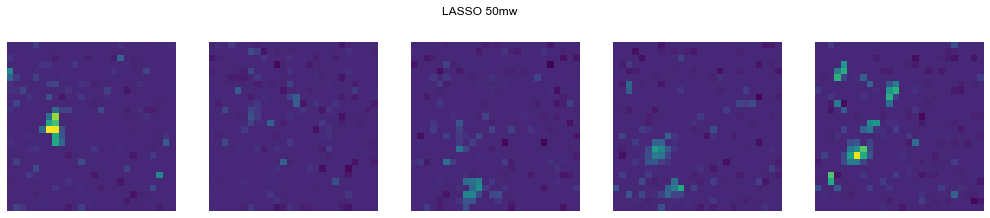

In [10]:
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 50mw')
vmin = np.min(lmap_50)
vmax = np.max(lmap_50)
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_50[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
plt.show()

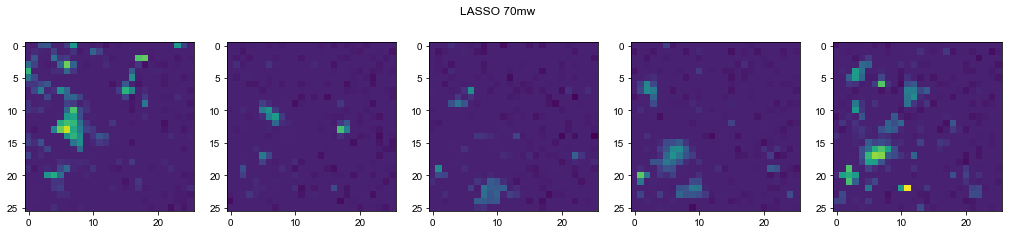

In [11]:
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 70mw')
vmin = np.min(lmap_70)
vmax = np.max(lmap_70)
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_70[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
#     plt.axis('off')
# plt.savefig('figs/experimental_data/speckle_analysis/lasso_maps_70mw.png', format='png', bbox_inches='tight')
plt.show()

In [10]:
speckle_locs = {}
speckle_locs['-75'] = np.array([
    [2, 18],
    [13, 6],
    [9, 18]
])

speckle_locs['-50'] = np.array([
    [13, 17]
])

speckle_locs['25'] = np.array([
    [22, 11]
])

In [11]:
def get_loc(loc, plane):
    return plane[np.array(range(dim**2)).reshape([dim, dim]).T[loc[0], loc[1]]]

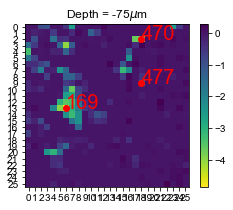

In [12]:
cdepth = -75
curr_plane = np.where(targets[:, -1] == cdepth)[0]

plt.figure(figsize=(4, 3))
plt.imshow(lmap_70[curr_plane].reshape([dim, dim]).T, cmap='viridis_r')
plt.colorbar()
plt.scatter(speckle_locs[str(cdepth)][:, 1], speckle_locs[str(cdepth)][:, 0], marker='o', color='r')
for i in range(len(speckle_locs[str(cdepth)])):
    plt.text(speckle_locs[str(cdepth)][i, 1], speckle_locs[str(cdepth)][i, 0], get_loc(speckle_locs[str(cdepth)][i], curr_plane), fontsize=20, color='red')
plt.xticks(range(dim))
plt.yticks(range(dim))
plt.title('Depth = ' + str(cdepth) + '$\mu$m')
# plt.savefig('figs/experimental_data/speckle_analysis/roi_plane_-75_map_70mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

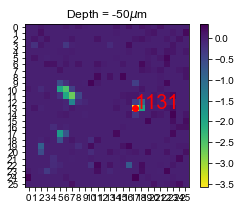

In [13]:
cdepth = -50
curr_plane = np.where(targets[:, -1] == cdepth)[0]

plt.figure(figsize=(4, 3))
plt.imshow(lmap_70[curr_plane].reshape([dim, dim]).T, cmap='viridis_r')
plt.colorbar()
plt.scatter(speckle_locs[str(cdepth)][:, 1], speckle_locs[str(cdepth)][:, 0], marker='o', color='r')
for i in range(len(speckle_locs[str(cdepth)])):
    plt.text(speckle_locs[str(cdepth)][i, 1], speckle_locs[str(cdepth)][i, 0], get_loc(speckle_locs[str(cdepth)][i], curr_plane), fontsize=20, color='red')
plt.xticks(range(dim))
plt.yticks(range(dim))
plt.title('Depth = ' + str(cdepth) + '$\mu$m')
# plt.savefig('figs/experimental_data/speckle_analysis/roi_plane_-50_map_70mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

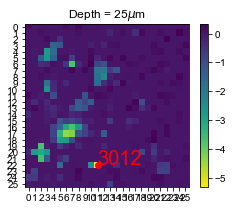

In [14]:
cdepth = 25
curr_plane = np.where(targets[:, -1] == cdepth)[0]

plt.figure(figsize=(4, 3))
plt.imshow(lmap_70[curr_plane].reshape([dim, dim]).T, cmap='viridis_r')
plt.colorbar()
plt.scatter(speckle_locs[str(cdepth)][:, 1], speckle_locs[str(cdepth)][:, 0], marker='o', color='r')
for i in range(len(speckle_locs[str(cdepth)])):
    plt.text(speckle_locs[str(cdepth)][i, 1], speckle_locs[str(cdepth)][i, 0], get_loc(speckle_locs[str(cdepth)][i], curr_plane), fontsize=20, color='red')
plt.xticks(range(dim))
plt.yticks(range(dim))
plt.title('Depth = ' + str(cdepth) + '$\mu$m')
# plt.savefig('figs/experimental_data/speckle_analysis/roi_plane_+25_map_70mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

In [15]:
nstim_50_mw = np.where(stimuli[:, -1] == 50)[0][-1]
order = order.astype(int)
trial_len = 300
example_locs = [169, 470, 477, 1131, 3012]

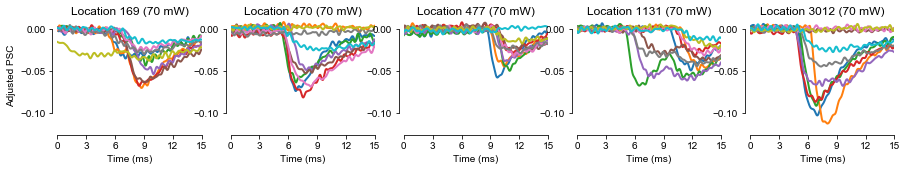

In [16]:
plt.figure(figsize=(15, 2))
for indx, loc in enumerate(example_locs):
    plt.subplot(1, len(example_locs), indx + 1)
    tmp = np.where(order == loc)[0]
    tmp = tmp[tmp > nstim_50_mw]
    plt.plot(responses[tmp].T, linewidth=2)
    plt.xlim([0, trial_len])
    plt.ylim([-0.12, 0.01])
    plt.xticks(np.arange(0, trial_len + 1, 60))
    plt.gca().set_xticklabels(np.arange(0, 16, 3))
    plt.xlabel('Time (ms)')
    if indx == 0: plt.ylabel('Adjusted PSC')
    sns.despine(trim=True, offset=5)
    plt.title('Location %s (70 mW)'%loc)
# plt.savefig('figs/experimental_data/speckle_analysis/psc_traces_for_speckles.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

In [17]:
xmin = 194
xmax = 319

centroids = np.array([
    [202, 296],
    [200, 260],
    [225, 282],
    [241, 309],
    [255, 290],
    [235, 268],
    [226, 245],
    [242, 245],
    [258, 235],
    [284, 252],
    [311, 252],
    [300, 286],
    [192, 215],
    [325, 292]
])

In [18]:
img_cropped = img[xmin+10:xmax+10, xmin-10:xmax-10]
img_cropped_noshift = img[xmin:xmax, xmin:xmax]

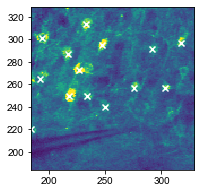

In [19]:
plt.figure(figsize=(3, 3))
plt.imshow(img[:, :, 1], origin='lower', cmap='viridis')
# plt.imshow(img[:, :, 1], origin='lower', cmap='gray')
plt.scatter(centroids[:, 0] - 8, centroids[:, 1] + 5, marker='x', color='w')
plt.xlim([xmin - 10, xmax + 10])
plt.ylim([xmin - 10, xmax + 10])
plt.show()

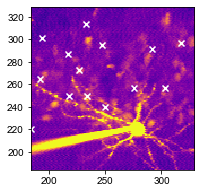

In [20]:
plt.figure(figsize=(3, 3))
plt.imshow(img[:, :, 0], origin='lower', cmap='plasma')
plt.scatter(centroids[:, 0] - 8, centroids[:, 1] + 5, marker='x', color='w')
plt.xlim([xmin - 10, xmax + 10])
plt.ylim([xmin - 10, xmax + 10])
# plt.savefig('figs/experimental_data/speckle_analysis/anatomical_mcherry_channel_with_rois.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

# Fit circuit model

In [12]:
def init_hist_dict(n_dicts=1, descriptors=[]):
    lsd = [{} for _ in range(n_dicts)]
    for d in lsd:
        d['utility'] = []
        for descr in descriptors:
            d[descr] = []
    if n_dicts == 1:
        return lsd[0]
    else:
        return lsd

def record_hist(d, model, umap=None, descriptors=[]):
    if 'utility' in descriptors:
        d['utility'] += [umap]
    for descr in descriptors:
        d[descr] += [model.state[descr]]
        
descriptors = ['mu', 'beta', 'alpha', 'lam', 'phi_map', 'phi_cov', 'shape', 'rate']

In [16]:
N = len(cell_locs)

interp = 0.25

priors = {
    'alpha': 0.5 * np.ones(N),
    'Omega': np.array([np.diag([0.00389425, 0.00391111, 0.00074478]) for n in range(N)]),
    'mu': np.zeros(N),
    'beta': 5 * np.ones(N),
    'shape': 1,
    'rate': 1,
    'phi_map': np.c_[0.03203156 * np.ones(N), 5.216092 * np.ones(N)],
    'phi_cov': np.array([np.array([[1e-1, 0], [0, 1e1]]) for _ in range(N)])
}

fit_options = {
    'iters': 10,
    'newton_steps': 15, # default 10
    'lam_update': 'monte-carlo',
    'num_mc_samples': 10, # default 5
    'verbose': False,
    'init_t': 1e1,
    't_loops': 3, # default 3
    't_mult': 15,
    'interp': interp
}

ensemble_size = 1
model = adaprobe.Model(cell_locs, priors=priors, variational_model='omega-3d')

In [17]:
K = len(y)

In [18]:
hist = init_hist_dict(ensemble_size, descriptors=descriptors)

for i in range(ensemble_size):
    t1 = time.time()
    for k in range(K):
        print('trial %i/%i'%(k + 1, K), end='\r')
        model.update(y[k], (L[k], I[k]), fit_options=fit_options, method='cavi_online_spike_and_slab_3d_omega')
        record_hist(hist, model, descriptors=descriptors)

    t2 = time.time()
    print('run %i: elapsed time %.2f'%(i, t2 - t1))

run 0: elapsed time 97.47


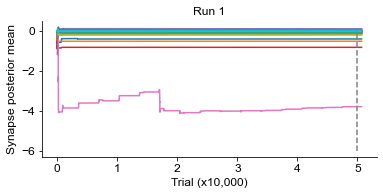

In [19]:
# Plot synapse means

plt.figure(figsize=(6, 2.5))
plt.plot(np.array(hist['mu']))
plt.xticks(np.arange(0, 2*K + 1, 1e4), fontsize=fontsize)
plt.gca().set_xticklabels(np.arange(0, 11, 1))
plt.plot([5e4, 5e4], [-6, 0], '--', color='gray')
plt.title('Run %i'%(i+1), fontsize=fontsize)
for loc in ['top', 'right']:
    plt.gca().spines[loc].set_visible(False)
if i == 0:
    plt.ylabel('Synapse posterior mean', fontsize=fontsize)
    plt.xlabel('Trial (x10,000)', fontsize=fontsize)
    plt.yticks(np.arange(-6, 2, 2), fontsize=fontsize)
else:
    plt.yticks([])
plt.show()

KeyError: 0

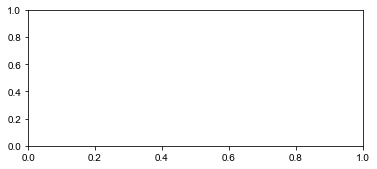

In [20]:
# Plot synapse means

plt.figure(figsize=(ensemble_size*6, 2.5))
for i in range(ensemble_size):
    plt.subplot(1, ensemble_size, i + 1)
    plt.plot(np.array(hist[i]['mu']))
#     plt.xlim([0, K])
    plt.xticks(np.arange(0, 2*K + 1, 1e4), fontsize=fontsize)
    plt.gca().set_xticklabels(np.arange(0, 11, 1))
    plt.plot([5e4, 5e4], [-6, 0], '--', color='gray')
    plt.title('Run %i'%(i+1), fontsize=fontsize)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    if i == 0:
        plt.ylabel('Synapse posterior mean', fontsize=fontsize)
        plt.xlabel('Trial (x10,000)', fontsize=fontsize)
        plt.yticks(np.arange(-6, 2, 2), fontsize=fontsize)
    else:
        plt.yticks([])
plt.show()

In [ ]:
# Plot connection probs

plt.figure(figsize=(ensemble_size*4.5, 2.5))
for i in range(ensemble_size):
    plt.subplot(1, ensemble_size, i + 1)
    plt.plot(np.array(hist[i]['alpha']))
#     plt.xlim([0, K])
    plt.ylim([-0.05, 1.05])
    plt.xticks(np.arange(0, 2*K+1, 1e4), fontsize=fontsize)
    plt.gca().set_xticklabels(np.arange(0, 11, 1))
    plt.title('Run %i'%(i+1), fontsize=fontsize)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    if i == 0:
        plt.ylabel('Posterior connection\nprobability', fontsize=fontsize)
        plt.xlabel('Trial (x10,000)', fontsize=fontsize)
        plt.yticks([0, 0.5, 1], fontsize=fontsize)
    else:
        plt.yticks([])
plt.show()

In [21]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [22]:
# for j in range(ensemble_size):
for j in [1]:
    cntr = 1
    power = 70
    model = models[j]
    phi = model.state['phi_map']
    cov = model.state['phi_cov']
    phi_0_lower = [phi[i, 0] - np.sqrt(cov[i][0, 0]) for i in range(N)]
    phi_0_upper = [phi[i, 0] + np.sqrt(cov[i][0, 0]) for i in range(N)]
    phi_1_lower = [phi[i, 1] - np.sqrt(cov[i][1, 1]) for i in range(N)]
    phi_1_upper = [phi[i, 1] + np.sqrt(cov[i][1, 1]) for i in range(N)]
    omega = model.state['omega']
    
    plt.figure(figsize=(10, 18))
    for i in range(N):
        # Set up receptive fields
        xran = np.arange(0, 50, 0.01)
        fn = sigmoid(phi[i, 0] * power * np.exp(-omega[i] * xran) - phi[i, 1])
        fn_lower = sigmoid(phi_0_lower[i] * power * np.exp(-omega[i] * xran) - phi_1_lower[i])
        fn_upper = sigmoid(phi_0_upper[i] * power * np.exp(-omega[i] * xran) - phi_1_upper[i])
        
        # Make plot
        plt.subplot(10, 5, cntr)
        plt.plot(xran, fn, 'k')
        plt.fill_between(xran, fn_lower, fn_upper, alpha=0.35, facecolor='firebrick', edgecolor='None')
        plt.ylim([-0.5e-1, 1 + 0.5e-1])
        plt.xticks([0, 25, 50])
        if cntr == 1:
            plt.ylabel('Spike\nprobability', fontsize=fontsize)
            plt.xlabel('Distance from\ncentroid ($\mu$m)', fontsize=fontsize)
        cntr += 1
    plt.tight_layout()
    plt.show()

NameError: name 'models' is not defined

In [ ]:
# def model_evidence(y, model, I, L, num_mc_samples=5):
#     m = np.array([I * np.exp(-model.state['omega'][n] * np.sum(np.square(L - model.cell_locs[n]), 1)) for n in range(N)])
#     phi = np.array([_sample_phi_independent_truncated_normals(
#             model.state['phi_map'][n], model.state['phi_cov'][n], num_mc_samples=num_mc_samples
#         ) for n in range(N)])
#     f = np.zeros((num_mc_samples, N, K))
#     s = np.zeros_like(f)
#     w = np.zeros((num_mc_samples, N))
#     sig = np.zeros(num_mc_samples)
#     llh = np.zeros(num_mc_samples)
#     for i in range(num_mc_samples):
#         f[i] = sigmoid(np.array([phi[n, i, 0] * m[n] - phi[n, i, 1] for n in range(N)]))
#         s[i] = np.random.rand(N, K) <= f[i]
#         w[i] = (np.random.rand(N) <= model.state['alpha']) * np.random.normal(model.state['mu'], model.state['beta'])
#         sig[i] = np.sqrt(1/np.random.gamma(model.state['shape'], 1/model.state['rate']))
#         llh[i] = np.sum(norm.pdf(y, w[i] @ s[i], sig[i]))
#     return np.mean(llh)

In [ ]:
ev = np.array([adaprobe.experimental_design.model_evidence(y, model, I, L, num_mc_samples=10) for model in models])
posterior_weights = ev/np.sum(ev)

In [ ]:
plt.figure(figsize=(4, 2))
plt.bar(np.arange(ensemble_size), posterior_weights)
plt.xticks(np.arange(ensemble_size))
for loc in ['top', 'right']:
    plt.gca().spines[loc].set_visible(False)
plt.xlabel('Model', fontsize=fontsize)
plt.ylabel('Evidence', fontsize=fontsize)
plt.show()

In [40]:
xrange = np.arange(-10, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

In [ ]:
alpha = np.sum([models[i].state['alpha'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
mu = np.sum([models[i].state['mu'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
beta = np.sum([models[i].state['beta'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
posteriors = np.array([alpha[n] * gaussf(mu[n], beta[n]) for n in range(N)])

In [ ]:

ymax = np.max(np.array([gaussf(models[i].state['mu'][n], models[i].state['beta'][n]) for i in range(ensemble_size) for n in range(N)]))
post_ens = np.array([alpha[n] * gaussf(mu[n], beta[n]) for i in range(ensemble_size) for n in range(N)])

plt.figure(figsize=(12, 2*(N/4)))
for n in range(N):
    plt.subplot(int(np.ceil(N/4)), 4, n + 1)
    
    # Plot posteriors
    for i in range(ensemble_size):
        postn = models[i].state['alpha'][n] * gaussf(models[i].state['mu'][n], models[i].state['beta'][n])
        plt.plot(xrange, postn, color='gray', alpha=0.5)
    plt.plot(xrange, post_ens[n], color='firebrick', linewidth=2)
    
    plt.ylim([-0.05, ymax + 0.05])
    plt.xlim(np.min(xrange), np.max(xrange))
    if n == 0: 
        plt.ylabel('Slab density', fontsize=fontsize)
plt.show()

In [41]:
alpha = model.state['alpha']
mu = model.state['mu']
beta = model.state['beta']
posteriors = np.array([alpha[n] * gaussf(mu[n], beta[n]) for n in range(N)])

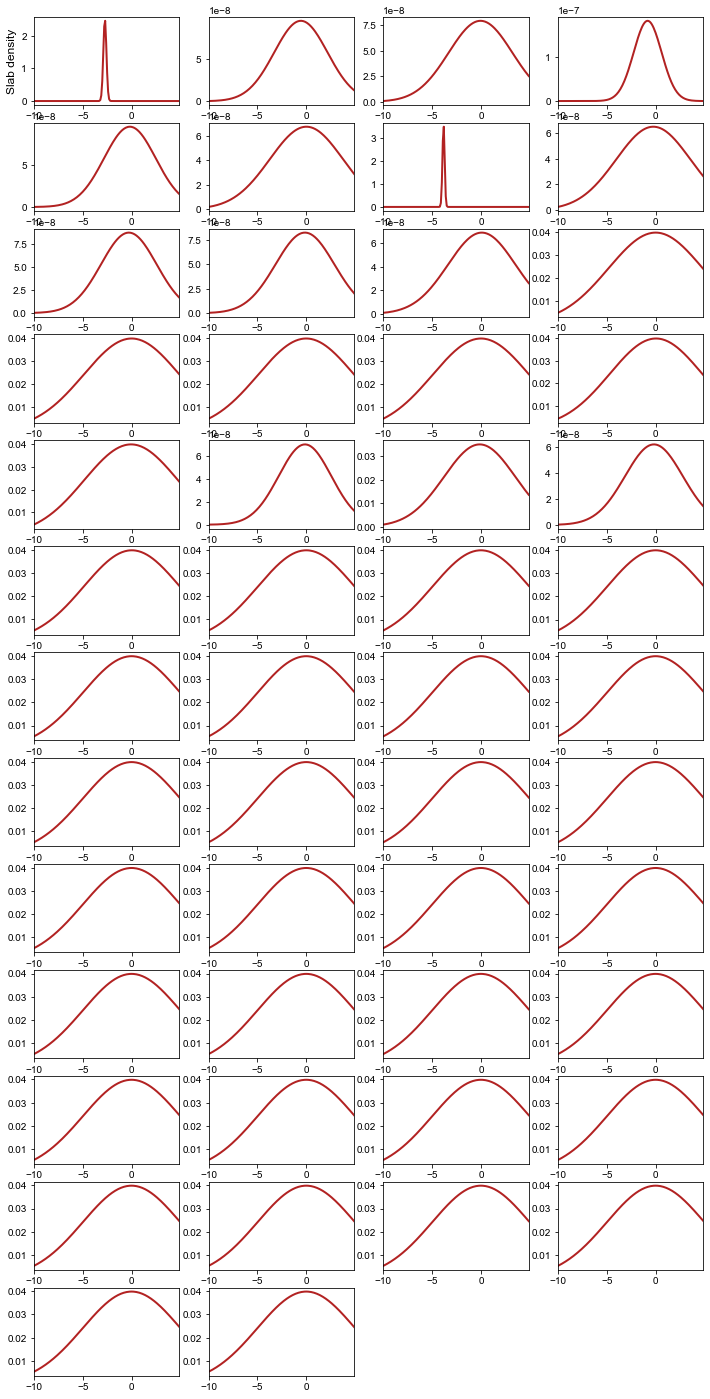

In [43]:

# ymax = np.max(np.array([gaussf(models[i].state['mu'][n], models[i].state['beta'][n]) for i in range(ensemble_size) for n in range(N)]))
post_ens = np.array([alpha[n] * gaussf(mu[n], beta[n]) for n in range(N)])

plt.figure(figsize=(12, 2*(N/4)))
for n in range(N):
    plt.subplot(int(np.ceil(N/4)), 4, n + 1)
    plt.plot(xrange, post_ens[n], color='firebrick', linewidth=2)
    
#     plt.ylim([-0.05, ymax + 0.05])
    plt.xlim(np.min(xrange), np.max(xrange))
    if n == 0: 
        plt.ylabel('Slab density', fontsize=fontsize)
plt.show()

## 50mW maps

In [44]:
spacing = 10
minx, maxx = np.min(cell_locs[:, 0]), np.max(cell_locs[:, 0])
miny, maxy = np.min(cell_locs[:, 1]), np.max(cell_locs[:, 1])
xr = np.arange(minx - spacing, maxx + spacing)
yr = np.arange(miny - spacing, maxy + spacing)
xgrid, ygrid = np.meshgrid(xr, yr)
grid = np.c_[xgrid.flatten(), ygrid.flatten()]

In [45]:
depths = np.unique(L[:, -1])
ndepths = len(depths)
dim = 26

In [ ]:
pred_maps_50 = {}
pred_maps_70 = {}
for d in depths:
    pred_maps_50[str(d)] = [
        adaprobe.experimental_design.posterior_predictive_map_on_plane(grid, d, 50, models[i], n_samples=20) for i in range(ensemble_size)
    ]
    pred_maps_70[str(d)] = [
        adaprobe.experimental_design.posterior_predictive_map_on_plane(grid, d, 70, models[i], n_samples=20) for i in range(ensemble_size)
    ]

In [ ]:
pred_map_50_bayes = {}
pred_map_70_bayes = {}
for d in depths:
    pred_map_50_bayes[str(d)] = adaprobe.experimental_design.posterior_predictive_map_on_plane_bayes_ensemble(
        grid, y, plane=d, power=50, I_hist=I, L_hist=L, models=models, n_samples=60)
    pred_map_70_bayes[str(d)] = adaprobe.experimental_design.posterior_predictive_map_on_plane_bayes_ensemble(
        grid, y, plane=d, power=70, I_hist=I, L_hist=L, models=models, n_samples=60)

In [ ]:
# vmax = np.max(np.array([pred_map for pred_map in pred_maps_70.values()]))
# vmin = np.min(np.array([pred_map for pred_map in pred_maps_70.values()]))

In [ ]:
fcoef = 3

In [ ]:
# Lasso maps
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 50mw')
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_50[curr_plane].reshape([dim, dim]), cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
# plt.savefig('figs/experimental_data/posterior_predictive_mean_lasso_50mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Bayesian model combination')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(pred_map_50_bayes[str(d)].reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
# plt.savefig('figs/experimental_data/posterior_predictive_mean_bayes_ensemble_50mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()


plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Ensemble average')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(np.mean(pred_maps_50[str(d)], 0).reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
plt.show()

for e in range(ensemble_size):
    plt.figure(figsize=(fcoef*ndepths, fcoef))
    plt.suptitle('Run %i'%(e + 1))
    for i, d in enumerate(depths):
        plt.subplot(1, ndepths, i + 1)
        plt.imshow(pred_maps_50[str(d)][e].reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
        plt.axis('off')
    plt.show()

## 70 mw maps

In [ ]:
# Lasso maps
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 70mw')
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_70[curr_plane].reshape([dim, dim]), cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
# plt.savefig('figs/experimental_data/posterior_predictive_mean_lasso_70mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Bayesian model combination')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(pred_map_70_bayes[str(d)].reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
# plt.savefig('figs/experimental_data/posterior_predictive_mean_bayes_ensemble_70mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Ensemble average')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(np.mean(pred_maps_70[str(d)], 0).reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
plt.show()
    
for e in range(ensemble_size):
    plt.figure(figsize=(fcoef*ndepths, fcoef))
    plt.suptitle('Run %i'%(e + 1))
    for i, d in enumerate(depths):
        plt.subplot(1, ndepths, i + 1)
        plt.imshow(pred_maps_70[str(d)][e].reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
        plt.axis('off')
    plt.show()